In [4]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

We will first create a 50 by 50 grid of spins 

In [5]:
N= 50

We will then generate some random grids of spins before we introduce it to a thermal environment 

In [6]:
init_random= np.random.random((N,N))
#lattice_n for negative spin
lattice_n= np.zeros((N,N))
#if lattice_n>=0.75, set spin=1, otherwise spin=-1
lattice_n[init_random>= 0.75] = 1
lattice_n[init_random<0.75] = -1

In [7]:
init_random= np.random.random((N,N))
#lattice_p for positive spin 
lattice_p= np.zeros((N,N))
lattice_p[init_random>= 0.25] = 1
lattice_p[init_random< 0.25] = -1

In [11]:
lattice_p

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ...,  1.,  1.,  1.]])

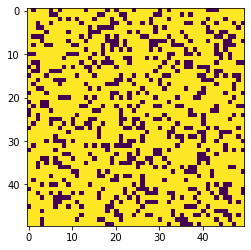

In [8]:
plt.imshow(lattice_p) #initial state

The energy equation is: $$\frac{E}{J}= - \Sigma_{<i,j>} σ_i σ_j$$ where J is the constant of proportionality. To obtain the sum of nearest neighbours $<i,j> σ_i σ_j$ we will create a convolutional kernel. 

In [9]:
def get_energy(lattice):
  kern= generate_binary_structure(2,1)
  kern[1][1]= False 
  arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
  return arr.sum()

**Implementing the Metropolis Algorithm:**
<br>
It takes in an initial grid of spins, number of iterations(time steps) and temperature(BJ because B=1/kT where k is the Boltzmann's constant and T is the temperature of the surroundings) and returns the total spin of all the particles  



In [10]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy): #all arguments are initial values
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1) #to keep check of spins and energies as the lattice changes with each iteration
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # change of state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum() #net spin/energy of new state
        net_energy[t] = energy
            
    return net_spins, net_energy

/usr/local/lib/python3.7/dist-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


The arrays and spins as the lattice changes to reach equilibrium is as follows:

In [11]:
spins, energies = metropolis(lattice_n, 1000000, 0.2, get_energy(lattice_n))


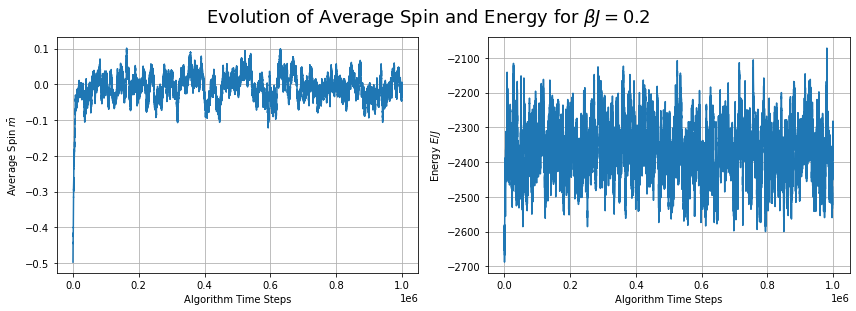

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.2', y=1.07, size=18)
plt.show()

This shows that as we increase the temperature(BJ) of a ferromagnetic material, there exists a certain point(critical temperature) after which the material loses it's magnetization. However by increasing the temperature, we are increasing the energy of the surroundings which adds an additional energy to the lattice system. 

We can get the average spin and energy for the last 100000 points as follows: 


In [14]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs)) #standard deviation which can give us the heat capacity 
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**2
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

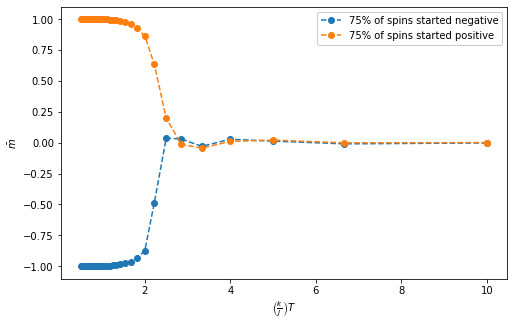

In [15]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

At cold temperatures, the energy of the surroundings is also low and thus it is favorable for the spins to align.As the temperature increases, the thermal bath produces more energy and there's a phase transition. 